## Load MNIST Data

In [5]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original') # 에러 발생 시 mnist-original.mat 파일 다운받아서 /scikit_learn_data/mldata 에 옮기면 해결

In [6]:
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([0., 0., 0., ..., 9., 9., 9.])}

In [7]:
X, y = mnist['data'], mnist['target']
X.shape, y.shape

((70000, 784), (70000,))

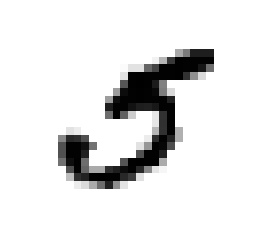

In [9]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

sample_digit = X[36000]
sample_digit_image = sample_digit.reshape(28, 28)
plt.imshow(sample_digit_image, cmap=matplotlib.cm.binary, interpolation='nearest')

plt.axis('off')
plt.show()

In [10]:
y[36000]

5.0

## Train / Test

In [11]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [13]:
import numpy as np

In [14]:
shuffle_idx = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_idx], y_train[shuffle_idx]

## Classifier 제작

### 이진분류기

#### 5인지 아닌지 분류하는 분류기 제작

In [15]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [16]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [17]:
sgd_clf.predict([sample_digit])

array([ True])

#### 성능 평가

In [22]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_idx, test_idx in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_idx]
    y_train_folds = y_train[train_idx]
    X_test_folds = X_train[test_idx]
    y_test_folds = y_train[test_idx]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    
    print(n_correct / len(y_pred))

0.87225
0.86055
0.85325


In [23]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91245, 0.9628 , 0.96815])

In [26]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [27]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.9117 , 0.9082 , 0.90905])

In [28]:
from sklearn.model_selection import  cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=5)

In [29]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53603,   976],
       [ 1453,  3968]])

In [36]:
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score

print('Precision Score: {}'.format(precision_score(y_train_5, y_train_pred)))
print('Recall Score: {}'.format(recall_score(y_train_5, y_train_pred)))
print('F1 Score: {}'.format(f1_score(y_train_5, y_train_pred)))

Precision Score: 0.8025889967637541
Recall Score: 0.7319682715366168
F1 Score: 0.7656536420646407


In [37]:
y_scores = sgd_clf.decision_function([sample_digit])
y_scores

array([75936.18049166])

In [39]:
threshold = 0
y_sample_digit_pred = (y_scores > threshold)
y_sample_digit_pred

array([ True])

In [42]:
threshold = 80000
y_sample_digit_pred = (y_scores > threshold)
y_sample_digit_pred

array([False])

In [43]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [44]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

/Users/jinhong/miniconda3/envs/handson/lib/python3.5/site-packages/matplotlib/legend.py:641: UserWarning: Unrecognized location "center_left". Falling back on "best"; valid locations are
	best
	center
	upper center
	upper left
	lower left
	upper right
	lower center
	right
	lower right
	center right
	center left

  % (loc, '\n\t'.join(self.codes)))


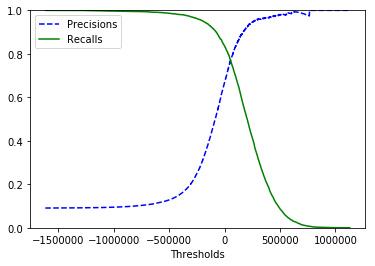

In [46]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precisions')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recalls')
    plt.xlabel('Thresholds')
    plt.legend(loc='center_left')
    plt.ylim([0, 1])
    plt.show()
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)


In [54]:
y_train_pred_90 = (y_scores > 100000)
print('Precision Score: {}'.format(precision_score(y_train_5, y_train_pred_90)))
print('Precision Score: {}'.format(recall_score(y_train_5, y_train_pred_90)))

Precision Score: 0.8337742504409171
Precision Score: 0.697657258808338


### ROC curve

In [55]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

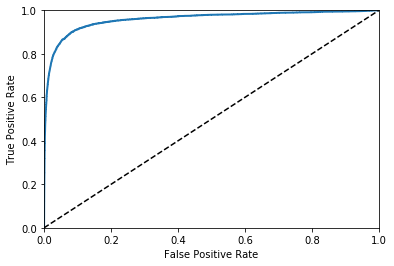

In [57]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show
    
plot_roc_curve(fpr, tpr)

In [58]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9592302040891841

In [59]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probs_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [63]:
y_scores_forest = y_probs_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

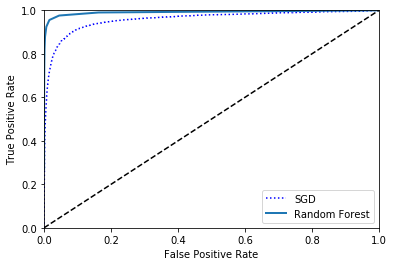

In [64]:
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc='lower right')

In [65]:
roc_auc_score(y_train_5, y_scores_forest)

0.9914039551711483

## Multiclass Classifier

In [66]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([sample_digit])

array([5.])

In [67]:
sample_digit_scores = sgd_clf.decision_function([sample_digit])
sample_digit_scores

array([[-273201.8662585 , -577278.2693727 , -405682.67411092,
         -98121.52637342, -208448.25115413,   75936.18049166,
        -635649.67178951, -388473.62572648, -679402.95455869,
        -632455.16678692]])

In [69]:
print(np.argmax(sample_digit_scores))
print(sgd_clf.classes_, sgd_clf.classes_[5])

5
[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.] 5.0


In [70]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([sample_digit]), len(ovo_clf.estimators_)

(array([5.]), 45)

In [72]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([sample_digit])

array([5.])

In [73]:
forest_clf.predict_proba([sample_digit])

array([[0.1, 0. , 0. , 0. , 0. , 0.9, 0. , 0. , 0. , 0. ]])

In [77]:
print('SGD CV Accuracy: {}'.format(cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')))
print('RF CV Accuracy: {}'.format(cross_val_score(forest_clf, X_train, y_train, cv=3, scoring='accuracy')))

SGD CV Accuracy: [0.87027594 0.85954298 0.86778017]
RF CV Accuracy: [0.94081184 0.93679684 0.94099115]


In [78]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

print('SGD CV Accuracy: {}'.format(cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')))
print('RF CV Accuracy: {}'.format(cross_val_score(forest_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')))

SGD CV Accuracy: [0.91156769 0.90759538 0.90908636]
RF CV Accuracy: [0.94076185 0.93674684 0.94104116]


### Analysis Error

In [79]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5749,    2,   19,   11,   11,   39,   43,    6,   40,    3],
       [   2, 6478,   46,   29,    5,   37,    7,    7,  121,   10],
       [  62,   34, 5320,  107,   81,   26,   94,   65,  155,   14],
       [  52,   40,  146, 5350,    6,  212,   35,   51,  143,   96],
       [  26,   29,   36,   10, 5377,    6,   53,   28,   84,  193],
       [  67,   43,   37,  183,   82, 4582,  109,   30,  190,   98],
       [  34,   25,   46,    2,   48,   93, 5615,    7,   48,    0],
       [  27,   27,   67,   37,   56,   10,    5, 5786,   16,  234],
       [  44,  171,   65,  172,   15,  152,   54,   28, 5018,  132],
       [  43,   42,   24,   88,  166,   28,    2,  184,   82, 5290]])

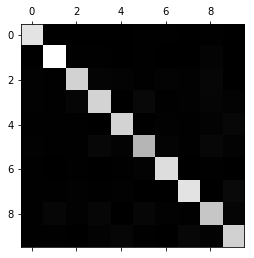

In [80]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

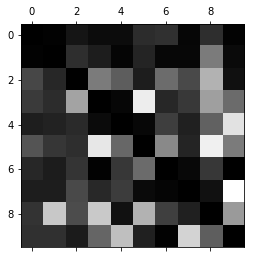

In [81]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_max = conf_mx / row_sums

np.fill_diagonal(norm_conf_max, 0)
plt.matshow(norm_conf_max, cmap=plt.cm.gray)
plt.show()

## Multi-label Classifier

In [82]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

In [83]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [84]:
knn_clf.predict([sample_digit])

array([[False,  True]])

In [86]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3, n_jobs=-1)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

Process ForkPoolWorker-8:
Process ForkPoolWorker-7:
Process ForkPoolWorker-6:
Process ForkPoolWorker-5:
Process ForkPoolWorker-4:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/jinhong/miniconda3/envs/handson/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/Users/jinhong/miniconda3/envs/handson/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/Users/jinhong/miniconda3/envs/handson/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/Users/jinhong/miniconda3/envs/handson/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/Users/jinhong/miniconda3/envs/handson/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/Users/jinhong/miniconda3/envs/handson/lib

KeyboardInterrupt: 

## Multioutput Classifier

In [91]:
# Picxel Nosie
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [93]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

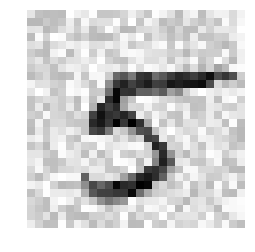

In [102]:
sample_index = 5500
plot_digits(X_test_mod[sample_index].reshape(1, -1))

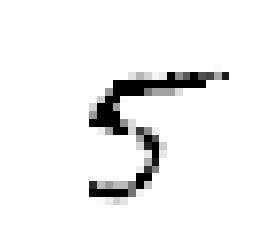

In [101]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[sample_index]])

plot_digits(clean_digit)

## Practice